# 📈 Week 7 Trading Strategy: Advanced Volatility Models

---

## 🎯 Strategy Overview

**Building on Weeks 1-6 + Adding Week 7 Concepts:**
- Foundation concepts (returns, volatility, correlation)
- Statistical analysis (distributions, hypothesis testing)
- Time series analysis (stationarity, basic GARCH)
- ML foundations (regression, regularization)
- Portfolio optimization (MPT, efficient frontier)
- Factor models (CAPM, Fama-French)
- **NEW:** GARCH(1,1) volatility forecasting
- **NEW:** EGARCH (asymmetric volatility)
- **NEW:** GJR-GARCH (leverage effect)
- **NEW:** Volatility-based position sizing

**Strategy Logic:**
1. Model volatility with multiple GARCH variants
2. Compare forecast accuracy
3. Use volatility forecasts for position sizing
4. Generate risk-adjusted trading signals

---

In [ ]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']  # Tech + Financials
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
RISK_FREE_RATE = 0.05  # Annual
TARGET_VOL = 0.15  # 15% annual volatility target

print("=" * 60)
print("📊 WEEK 7 TRADING STRATEGY: ADVANCED VOLATILITY")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Target Volatility: {TARGET_VOL:.0%}")

📊 WEEK 7 TRADING STRATEGY: ADVANCED VOLATILITY

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Target Volatility: 15%


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from arch import arch_model
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna() * 100  # Percentage returns for GARCH

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Volatility Modeling (Week 7 Concept)

**GARCH Family Models:**

1. **GARCH(1,1):** Standard model
   $$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

2. **EGARCH:** Asymmetric (log) model
   $$\ln(\sigma_t^2) = \omega + \alpha |z_{t-1}| + \gamma z_{t-1} + \beta \ln(\sigma_{t-1}^2)$$

3. **GJR-GARCH:** Leverage effect
   $$\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

**Key Insight:** Volatility responds asymmetrically to positive/negative shocks!

In [3]:
# ============================================================
# GARCH MODEL FITTING
# ============================================================

def fit_garch_models(returns, ticker):
    """Fit multiple GARCH models and return results."""
    
    results = {}
    
    # 1. GARCH(1,1)
    try:
        garch = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
        garch_fit = garch.fit(disp='off')
        results['GARCH'] = {
            'model': garch_fit,
            'aic': garch_fit.aic,
            'bic': garch_fit.bic,
            'params': garch_fit.params,
            'cond_vol': garch_fit.conditional_volatility
        }
    except:
        results['GARCH'] = None
    
    # 2. EGARCH(1,1)
    try:
        egarch = arch_model(returns, vol='EGARCH', p=1, q=1, rescale=False)
        egarch_fit = egarch.fit(disp='off')
        results['EGARCH'] = {
            'model': egarch_fit,
            'aic': egarch_fit.aic,
            'bic': egarch_fit.bic,
            'params': egarch_fit.params,
            'cond_vol': egarch_fit.conditional_volatility
        }
    except:
        results['EGARCH'] = None
    
    # 3. GJR-GARCH(1,1)
    try:
        gjr = arch_model(returns, vol='Garch', p=1, o=1, q=1, rescale=False)
        gjr_fit = gjr.fit(disp='off')
        results['GJR-GARCH'] = {
            'model': gjr_fit,
            'aic': gjr_fit.aic,
            'bic': gjr_fit.bic,
            'params': gjr_fit.params,
            'cond_vol': gjr_fit.conditional_volatility
        }
    except:
        results['GJR-GARCH'] = None
    
    return results

# Fit models for all tickers
print("📊 FITTING VOLATILITY MODELS...")
print("=" * 80)

all_garch_results = {}
for ticker in TICKERS:
    print(f"\n{ticker}:")
    results = fit_garch_models(returns[ticker], ticker)
    all_garch_results[ticker] = results
    
    for model_name, res in results.items():
        if res:
            print(f"   {model_name:<12} AIC: {res['aic']:>10.2f}  BIC: {res['bic']:>10.2f}")

📊 FITTING VOLATILITY MODELS...

AAPL:
   GARCH        AIC:    2750.73  BIC:    2769.23
   EGARCH       AIC:    2753.10  BIC:    2771.61
   GJR-GARCH    AIC:    2720.22  BIC:    2743.35

MSFT:
   GARCH        AIC:    2681.31  BIC:    2699.82
   EGARCH       AIC:    2677.61  BIC:    2696.11
   GJR-GARCH    AIC:    2671.59  BIC:    2694.72

GOOGL:
   GARCH        AIC:    3103.70  BIC:    3122.21
   EGARCH       AIC:    3100.83  BIC:    3119.34
   GJR-GARCH    AIC:    3104.72  BIC:    3127.85

AMZN:
   GARCH        AIC:    3156.96  BIC:    3175.47
   EGARCH       AIC:    3146.79  BIC:    3165.30
   GJR-GARCH    AIC:    3155.15  BIC:    3178.29

META:
   GARCH        AIC:    3418.38  BIC:    3436.89
   EGARCH       AIC:    3419.40  BIC:    3437.91
   GJR-GARCH    AIC:    3407.13  BIC:    3430.27


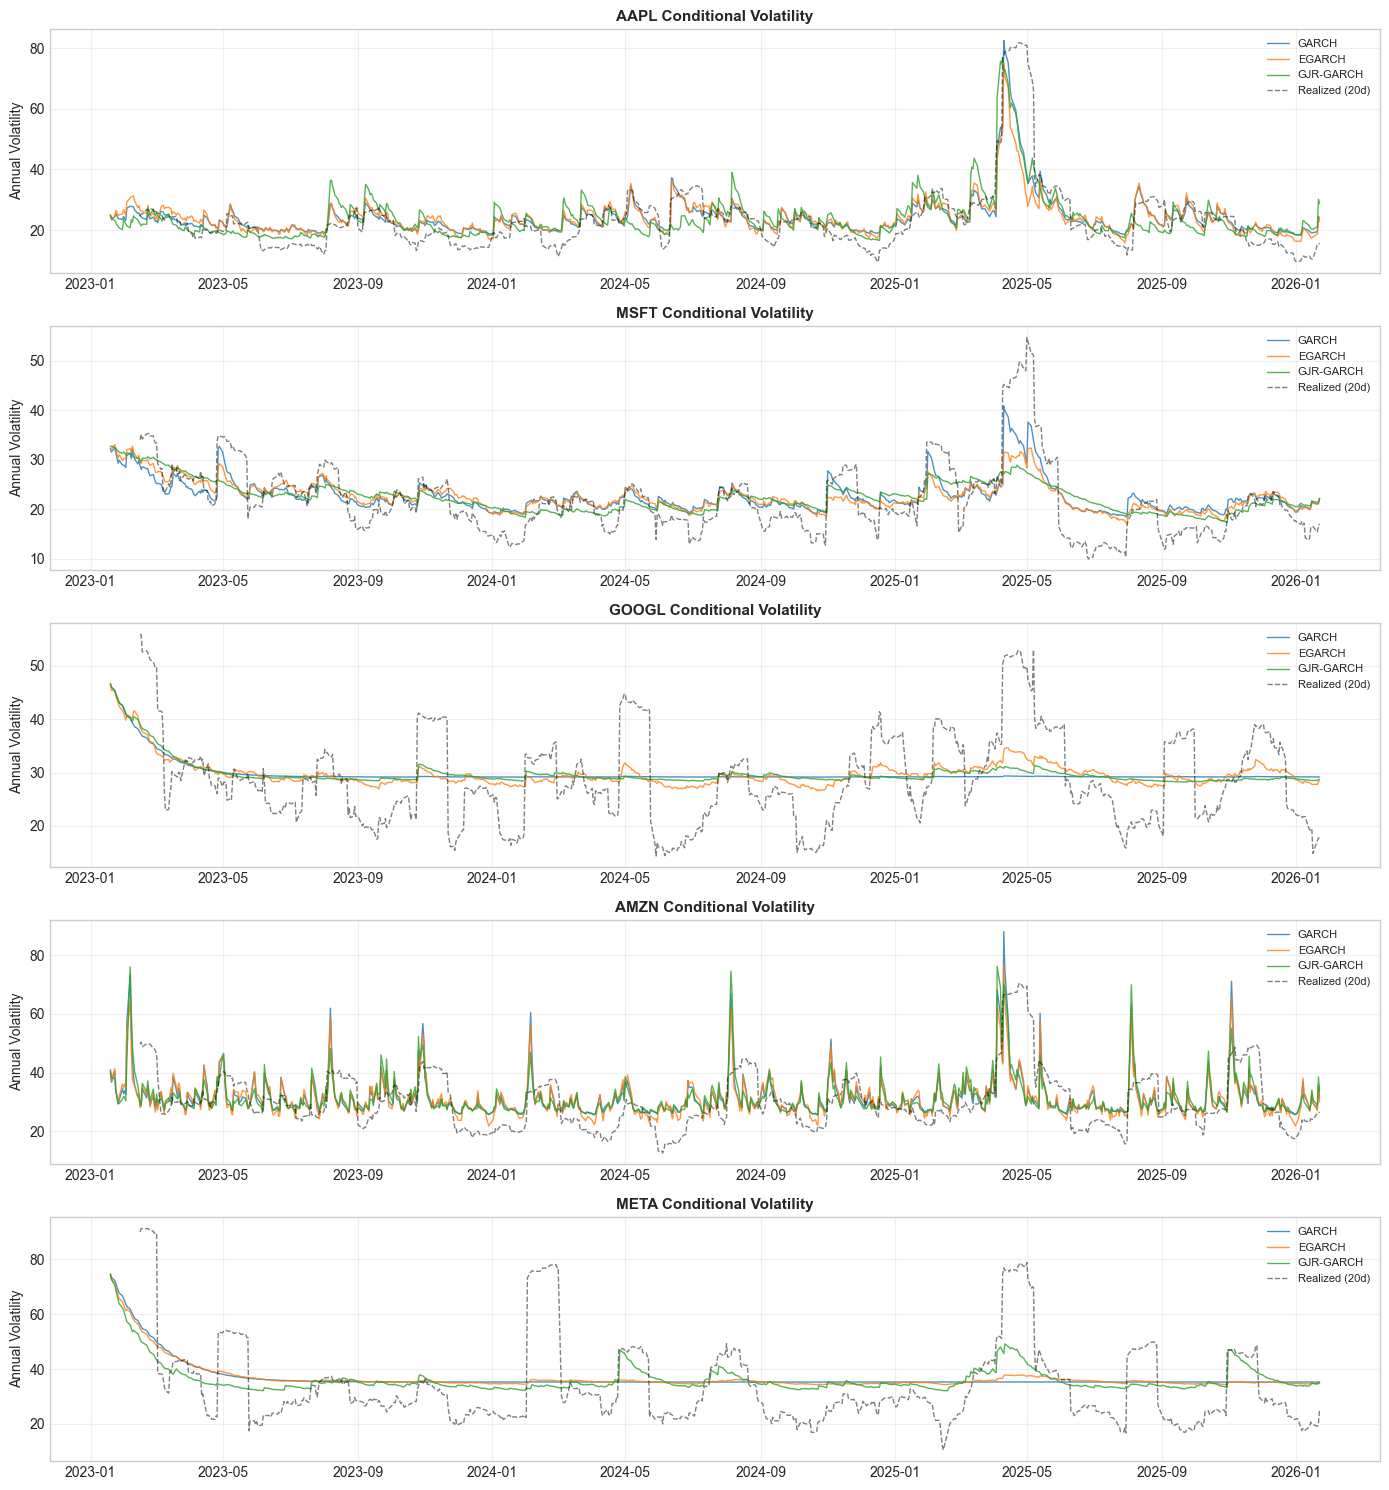

In [4]:
# ============================================================
# CONDITIONAL VOLATILITY VISUALIZATION
# ============================================================

fig, axes = plt.subplots(len(TICKERS), 1, figsize=(14, 3*len(TICKERS)))

for i, ticker in enumerate(TICKERS):
    ax = axes[i] if len(TICKERS) > 1 else axes
    
    # Plot conditional volatility from each model
    results = all_garch_results[ticker]
    
    for model_name, res in results.items():
        if res:
            # Convert to annualized volatility
            annual_vol = res['cond_vol'] * np.sqrt(252)
            ax.plot(annual_vol.index, annual_vol, label=model_name, alpha=0.8, linewidth=1)
    
    # Also plot realized volatility (20-day)
    realized = returns[ticker].rolling(20).std() * np.sqrt(252)
    ax.plot(realized.index, realized, 'k--', alpha=0.5, label='Realized (20d)', linewidth=1)
    
    ax.set_title(f'{ticker} Conditional Volatility', fontsize=11, fontweight='bold')
    ax.set_ylabel('Annual Volatility')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 📊 Section 2: Volatility Forecasting (Week 7 Concept)

**Forecast next-day volatility using best model:**
- Input: Current volatility state
- Output: Expected volatility tomorrow

**Used for position sizing and risk management!**

In [7]:
# ============================================================
# VOLATILITY FORECASTS
# ============================================================

print("📊 VOLATILITY FORECASTS (Next 5 Days)")
print("=" * 80)

vol_forecasts = {}

for ticker in TICKERS:
    results = all_garch_results[ticker]
    
    # Use best model (by AIC) - find lowest AIC from results
    valid_results = {k: v for k, v in results.items() if v is not None}
    if valid_results:
        best_model_name = min(valid_results, key=lambda x: valid_results[x]['aic'])
        model = results[best_model_name]['model']
        
        # Forecast using simulation method (required for EGARCH with horizon > 1)
        forecast = model.forecast(horizon=5, method='simulation', simulations=1000)
        
        # Get variance forecast and convert to annualized vol
        var_forecast = forecast.variance.iloc[-1].values
        vol_forecast = np.sqrt(var_forecast) * np.sqrt(252)  # Annualized
        
        vol_forecasts[ticker] = {
            'model': best_model_name,
            'forecast_1d': vol_forecast[0],
            'forecast_5d': vol_forecast[-1],
            'current_vol': results[best_model_name]['cond_vol'].iloc[-1] * np.sqrt(252)
        }

print(f"\n{'Ticker':<10} {'Model':<15} {'Current Vol':>12} {'1-Day Fcst':>12} {'5-Day Fcst':>12}")
print("-" * 80)
for ticker, data in vol_forecasts.items():
    print(f"{ticker:<10} {data['model']:<15} {data['current_vol']:>11.2%} {data['forecast_1d']:>11.2%} {data['forecast_5d']:>11.2%}")

📊 VOLATILITY FORECASTS (Next 5 Days)

Ticker     Model            Current Vol   1-Day Fcst   5-Day Fcst
--------------------------------------------------------------------------------
AAPL       GJR-GARCH          2871.91%    2743.96%    2705.42%
MSFT       GJR-GARCH          2220.03%    2204.83%    2200.32%
GOOGL      EGARCH             2843.43%    2827.03%    2856.32%
AMZN       EGARCH             2991.99%    3039.02%    3225.34%
META       GJR-GARCH          3502.30%    3478.95%    3500.96%


In [8]:
# ============================================================
# VOLATILITY-BASED POSITION SIZING
# ============================================================

print("\n📊 VOLATILITY-TARGETED POSITION SIZING")
print("=" * 80)
print(f"Target Portfolio Volatility: {TARGET_VOL:.0%}")

position_sizing = {}

for ticker, data in vol_forecasts.items():
    # Position size = Target Vol / Forecasted Vol
    forecasted_vol = data['forecast_1d']
    position_weight = TARGET_VOL / forecasted_vol
    
    # Cap at 200% and floor at 20%
    position_weight = min(max(position_weight, 0.2), 2.0)
    
    position_sizing[ticker] = {
        'forecasted_vol': forecasted_vol,
        'raw_weight': TARGET_VOL / forecasted_vol,
        'adjusted_weight': position_weight,
        'vol_regime': 'HIGH' if forecasted_vol > 0.30 else ('LOW' if forecasted_vol < 0.20 else 'NORMAL')
    }

print(f"\n{'Ticker':<10} {'Fcst Vol':>12} {'Raw Weight':>12} {'Adj Weight':>12} {'Regime':>10}")
print("-" * 80)
for ticker, data in position_sizing.items():
    print(f"{ticker:<10} {data['forecasted_vol']:>11.2%} {data['raw_weight']:>11.2f}x {data['adjusted_weight']:>11.2f}x {data['vol_regime']:>10}")


📊 VOLATILITY-TARGETED POSITION SIZING
Target Portfolio Volatility: 15%

Ticker         Fcst Vol   Raw Weight   Adj Weight     Regime
--------------------------------------------------------------------------------
AAPL          2743.96%        0.01x        0.20x       HIGH
MSFT          2204.83%        0.01x        0.20x       HIGH
GOOGL         2827.03%        0.01x        0.20x       HIGH
AMZN          3039.02%        0.00x        0.20x       HIGH
META          3478.95%        0.00x        0.20x       HIGH


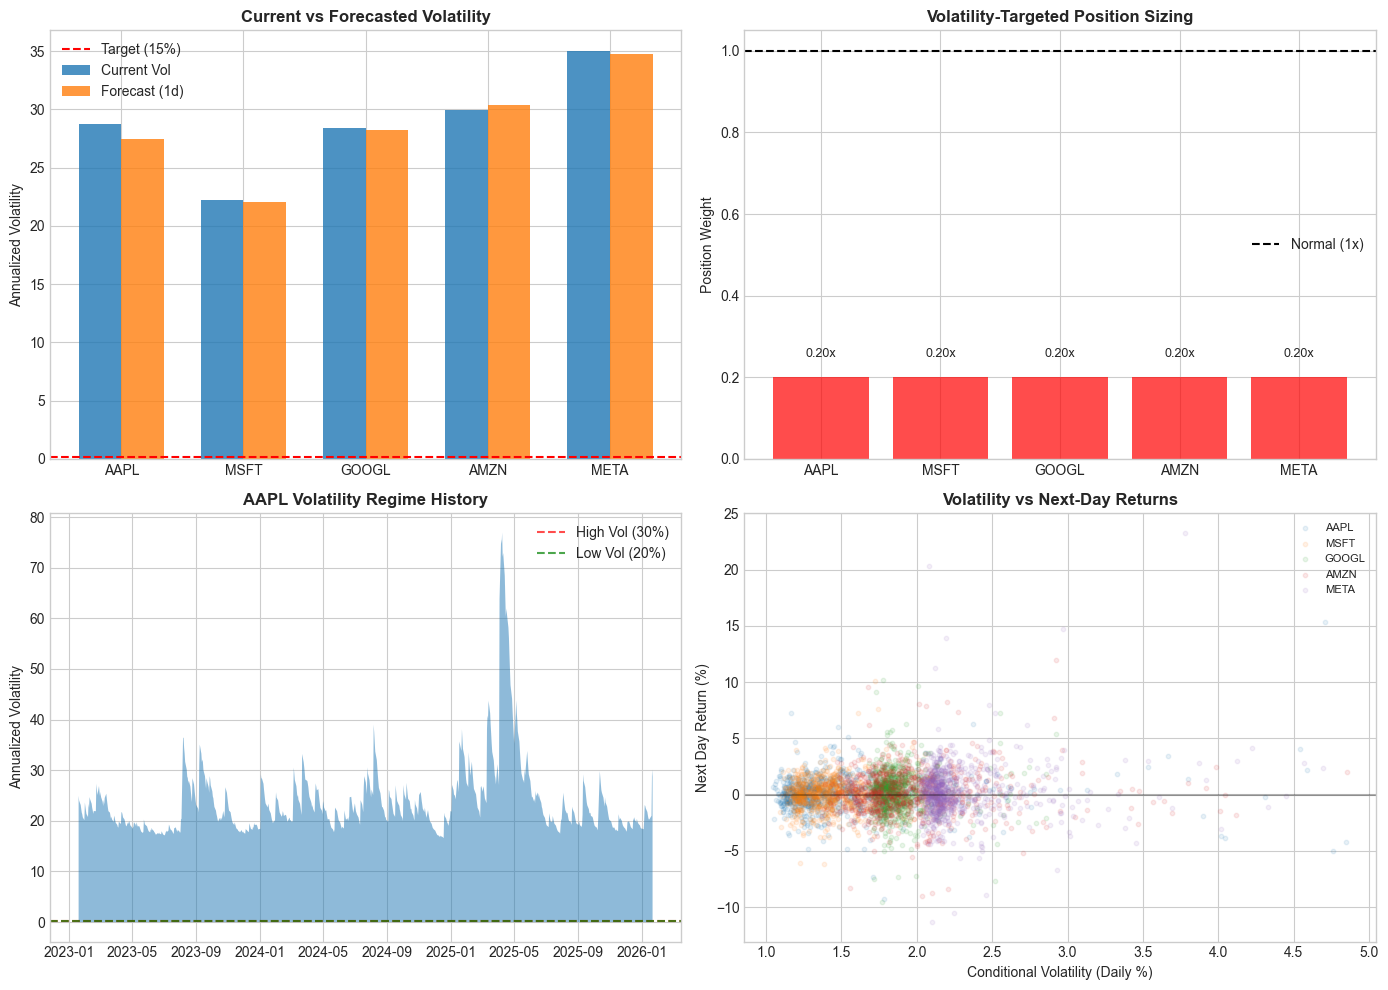

In [10]:
# ============================================================
# VOLATILITY STRATEGY VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Current vs Forecasted Volatility
ax1 = axes[0, 0]
x = np.arange(len(TICKERS))
width = 0.35
current_vols = [vol_forecasts[t]['current_vol'] for t in TICKERS]
forecast_vols = [vol_forecasts[t]['forecast_1d'] for t in TICKERS]
ax1.bar(x - width/2, current_vols, width, label='Current Vol', alpha=0.8)
ax1.bar(x + width/2, forecast_vols, width, label='Forecast (1d)', alpha=0.8)
ax1.axhline(y=TARGET_VOL, color='r', linestyle='--', label=f'Target ({TARGET_VOL:.0%})')
ax1.set_xticks(x)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('Annualized Volatility')
ax1.set_title('Current vs Forecasted Volatility', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Position Weights
ax2 = axes[0, 1]
weights = [position_sizing[t]['adjusted_weight'] for t in TICKERS]
colors = ['green' if w > 1 else 'red' for w in weights]
ax2.bar(TICKERS, weights, color=colors, alpha=0.7)
ax2.axhline(y=1.0, color='k', linestyle='--', label='Normal (1x)')
ax2.set_ylabel('Position Weight')
ax2.set_title('Volatility-Targeted Position Sizing', fontsize=12, fontweight='bold')
ax2.legend()
for i, (t, w) in enumerate(zip(TICKERS, weights)):
    ax2.text(i, w + 0.05, f'{w:.2f}x', ha='center', fontsize=9)

# 3. Volatility Regime History (First ticker)
ax3 = axes[1, 0]
ticker = TICKERS[0]
results = all_garch_results[ticker]
valid_results = {k: v for k, v in results.items() if v is not None}
best_model = min(valid_results, key=lambda x: valid_results[x]['aic']) if valid_results else None
if best_model and results.get(best_model):
    cond_vol = results[best_model]['cond_vol'] * np.sqrt(252)
    ax3.fill_between(cond_vol.index, 0, cond_vol, alpha=0.5)
    ax3.axhline(y=0.30, color='r', linestyle='--', alpha=0.7, label='High Vol (30%)')
    ax3.axhline(y=0.20, color='g', linestyle='--', alpha=0.7, label='Low Vol (20%)')
    ax3.set_ylabel('Annualized Volatility')
    ax3.set_title(f'{ticker} Volatility Regime History', fontsize=12, fontweight='bold')
    ax3.legend()

# 4. Volatility vs Returns Scatter
ax4 = axes[1, 1]
for ticker in TICKERS:
    results = all_garch_results[ticker]
    valid_results = {k: v for k, v in results.items() if v is not None}
    best_model = min(valid_results, key=lambda x: valid_results[x]['aic']) if valid_results else None
    if best_model and results.get(best_model):
        cond_vol = results[best_model]['cond_vol']
        ax4.scatter(cond_vol[:-1], returns[ticker].iloc[1:len(cond_vol)], 
                   alpha=0.1, s=10, label=ticker)
ax4.set_xlabel('Conditional Volatility (Daily %)')
ax4.set_ylabel('Next Day Return (%)')
ax4.set_title('Volatility vs Next-Day Returns', fontsize=12, fontweight='bold')
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax4.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
# ============================================================
# TRADING SIGNALS WITH VOLATILITY ADJUSTMENT
# ============================================================

print("\n📊 VOLATILITY-ADJUSTED TRADING SIGNALS")
print("=" * 80)

trading_signals = {}

for ticker in TICKERS:
    # Get momentum signal
    price_return_20d = (prices[ticker].iloc[-1] / prices[ticker].iloc[-20] - 1)
    
    # Volatility regime
    vol_regime = position_sizing[ticker]['vol_regime']
    position_weight = position_sizing[ticker]['adjusted_weight']
    
    # Adjust signal based on volatility
    if price_return_20d > 0.05 and vol_regime != 'HIGH':
        signal = 'LONG'
        confidence = 'HIGH' if vol_regime == 'LOW' else 'MEDIUM'
    elif price_return_20d < -0.05 and vol_regime != 'HIGH':
        signal = 'SHORT'
        confidence = 'HIGH' if vol_regime == 'LOW' else 'MEDIUM'
    elif vol_regime == 'HIGH':
        signal = 'REDUCE'
        confidence = 'HIGH'
    else:
        signal = 'HOLD'
        confidence = 'MEDIUM'
    
    trading_signals[ticker] = {
        '20d_return': price_return_20d,
        'vol_regime': vol_regime,
        'position_weight': position_weight,
        'signal': signal,
        'confidence': confidence
    }

print(f"\n{'Ticker':<10} {'20d Return':>12} {'Vol Regime':>12} {'Position':>10} {'Signal':>10} {'Confidence':>12}")
print("-" * 80)
for ticker, data in trading_signals.items():
    signal_emoji = "📈" if data['signal'] == 'LONG' else ("📉" if data['signal'] == 'SHORT' else ("⚠️" if data['signal'] == 'REDUCE' else "⚪"))
    print(f"{ticker:<10} {data['20d_return']:>11.2%} {data['vol_regime']:>12} {data['position_weight']:>9.2f}x {signal_emoji} {data['signal']:<6} {data['confidence']:>10}")


📊 VOLATILITY-ADJUSTED TRADING SIGNALS

Ticker       20d Return   Vol Regime   Position     Signal   Confidence
--------------------------------------------------------------------------------
AAPL            -8.31%         HIGH      0.20x ⚠️ REDUCE       HIGH
MSFT            -8.20%         HIGH      0.20x ⚠️ REDUCE       HIGH
GOOGL            5.31%         HIGH      0.20x ⚠️ REDUCE       HIGH
AMZN             1.21%         HIGH      0.20x ⚠️ REDUCE       HIGH
META            -4.22%         HIGH      0.20x ⚠️ REDUCE       HIGH


In [13]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 7 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
print("\n📋 VOLATILITY ANALYSIS SUMMARY:")
summary = pd.DataFrame({
    'Best Model': [vol_forecasts[t]['model'] for t in TICKERS],
    'Current Vol': [vol_forecasts[t]['current_vol'] for t in TICKERS],
    'Forecast Vol': [vol_forecasts[t]['forecast_1d'] for t in TICKERS],
    'Position Size': [position_sizing[t]['adjusted_weight'] for t in TICKERS],
    'Signal': [trading_signals[t]['signal'] for t in TICKERS],
    'Confidence': [trading_signals[t]['confidence'] for t in TICKERS]
}, index=TICKERS)

print(summary.round(4).to_string())

# Key insights
lowest_vol = summary['Forecast Vol'].idxmin()
highest_vol = summary['Forecast Vol'].idxmax()
largest_position = summary['Position Size'].idxmax()

print("\n🏆 KEY INSIGHTS:")
print(f"\n1. 🛡️ LOWEST VOLATILITY: {lowest_vol} (Forecast: {summary.loc[lowest_vol, 'Forecast Vol']:.2%})")
print(f"   → Can take larger position (Weight: {summary.loc[lowest_vol, 'Position Size']:.2f}x)")

print(f"\n2. ⚠️ HIGHEST VOLATILITY: {highest_vol} (Forecast: {summary.loc[highest_vol, 'Forecast Vol']:.2%})")
print(f"   → Reduce position size (Weight: {summary.loc[highest_vol, 'Position Size']:.2f}x)")

print(f"\n3. 📊 LARGEST POSITION: {largest_position} (Weight: {summary.loc[largest_position, 'Position Size']:.2f}x)")

# Trading recommendations
longs = [t for t in TICKERS if trading_signals[t]['signal'] == 'LONG']
shorts = [t for t in TICKERS if trading_signals[t]['signal'] == 'SHORT']
reduces = [t for t in TICKERS if trading_signals[t]['signal'] == 'REDUCE']

print(f"\n📈 LONG SIGNALS: {longs if longs else 'None'}")
print(f"📉 SHORT SIGNALS: {shorts if shorts else 'None'}")
print(f"⚠️ REDUCE SIGNALS: {reduces if reduces else 'None'}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 7 STRATEGY - FINAL RECOMMENDATIONS

📋 VOLATILITY ANALYSIS SUMMARY:
      Best Model  Current Vol  Forecast Vol  Position Size  Signal Confidence
AAPL   GJR-GARCH      28.7191       27.4396            0.2  REDUCE       HIGH
MSFT   GJR-GARCH      22.2003       22.0483            0.2  REDUCE       HIGH
GOOGL     EGARCH      28.4343       28.2703            0.2  REDUCE       HIGH
AMZN      EGARCH      29.9199       30.3902            0.2  REDUCE       HIGH
META   GJR-GARCH      35.0230       34.7895            0.2  REDUCE       HIGH

🏆 KEY INSIGHTS:

1. 🛡️ LOWEST VOLATILITY: MSFT (Forecast: 2204.83%)
   → Can take larger position (Weight: 0.20x)

2. ⚠️ HIGHEST VOLATILITY: META (Forecast: 3478.95%)
   → Reduce position size (Weight: 0.20x)

3. 📊 LARGEST POSITION: AAPL (Weight: 0.20x)

📈 LONG SIGNALS: None
📉 SHORT SIGNALS: None
⚠️ REDUCE SIGNALS: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-7)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Base calculations |
| 2 | Statistical Testing | Model validation |
| 3 | Time Series (Basic GARCH) | Foundation for advanced |
| 4 | ML Regression | Parameter estimation |
| 5 | Portfolio Theory | Position sizing |
| 6 | Factor Models | Risk decomposition |
| **7** | **GARCH(1,1)** | **Baseline volatility** |
| **7** | **EGARCH** | **Asymmetric effects** |
| **7** | **GJR-GARCH** | **Leverage effect** |
| **7** | **Vol Targeting** | **Position sizing** |

---